In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
df=pd.read_csv('DEMs_exp.csv')

df['SD'][df['SD'] == 3] = 0

df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df.head()

,hsa-miR-375,hsa-miR-29c*,hsa-miR-1258,hsa-miR-132*,hsa-miR-142-3p,hsa-miR-520c-3p,hsa-miR-302b,hsa-miR-204,hsa-miR-1468,hsa-miR-576-5p,hsa-miR-601,hsa-miR-609,hsa-miR-154,hsa-miR-508-3p,hsa-miR-942,hsa-miR-302d,hsa-miR-135b,hsa-miR-522,hsa-miR-488,hsa-miR-1262,hsa-miR-126*,hsa-miR-373,hsa-miR-483-3p,hsa-miR-133a,hsa-miR-190b,hsa-miR-598,hsa-miR-199b-5p,hsa-miR-1282,hsa-miR-1825,hsa-miR-130b*,hsa-miR-578,hsa-miR-520f,hsa-miR-26a-2*,hsa-miR-450a,hsa-miR-29b-1*,hsa-miR-615-3p,hsa-miR-892b,hsa-miR-1290,hsa-miR-556-3p,hsa-miR-98,...,hsa-miR-454*,hsa-miR-613,hsa-miR-302a,hsa-miR-376a*,hsa-miR-9,hsa-miR-520d-3p,hsa-miR-455-5p,hsa-miR-515-5p,hsa-miR-31*,hsa-miR-488*,hsa-miR-200a,hsa-miR-489,hsa-miR-1283,hsa-miR-566,hsa-miR-455-3p,hsa-miR-646,hsa-miR-519b-5p,hsa-miR-1245,hsa-miR-1291,hsa-miR-155*,hsa-miR-31,hsa-miR-518a-5p,hsa-miR-21*,hsa-miR-564,hsa-miR-933,hsa-miR-589,hsa-miR-545*,hsa-miR-520d-5p,hsa-miR-518d-5p,hsa-miR-96*,hsa-miR-136*,hsa-miR-491-3p,hsa-miR-568,hsa-miR-450b-5p,hsa-miR-556-5p,hsa-miR-10b*,hsa-miR-298,hsa-miR-889,hsa-miR-518d-3p,SD
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSM1512142,1.000000,4.262995,4.262995,1.0,6.420548,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,4.262995,1.0,1.000000,2.336774,1.0,2.336774,1.000000,1.0,1.000000,1.000000,6.728644,5.450346,1.0,1.000000,1.000000,2.336774,6.248638,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.450346,4.262995,5.014422,1.0,4.262995,...,1.000000,1.0,1.0,1.0,4.262995,1.0,1.000000,7.828533,7.828533,7.059014,6.728644,8.273836,6.728644,7.319222,7.319222,9.504007,8.052603,6.248638,6.420548,4.262995,7.059014,8.455011,7.059014,7.828533,8.373233,6.248638,4.262995,6.420548,7.222831,6.728644,5.450346,6.420548,6.248638,5.781078,7.059014,6.038019,8.455011,1.000000,5.450346,0.0
GSM1512143,1.000000,1.000000,1.000000,1.0,4.370692,1.000000,1.0,1.0,1.0,1.0,1.391073,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.391073,1.0,1.000000,3.136886,6.436324,5.240589,1.0,3.136886,3.136886,1.000000,6.284242,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.240589,4.370692,1.391073,1.0,3.846243,...,1.000000,1.0,1.0,1.0,3.846243,1.0,1.391073,8.349497,8.656972,6.356608,6.436324,8.090505,6.170350,6.529228,7.960402,8.606451,7.835585,4.370692,7.004594,4.370692,7.336514,7.687020,4.370692,7.275976,8.201368,6.067018,5.062997,5.628266,8.431464,8.285002,6.170350,6.684122,6.836845,5.949447,7.336514,6.284242,7.150665,5.062997,5.062997,0.0
GSM1512144,1.000000,4.888494,1.000000,1.0,7.254011,1.654871,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,5.710041,1.000000,1.0,1.000000,1.000000,1.0,5.406824,1.000000,5.710041,6.701950,1.0,6.167703,1.654871,1.000000,5.824839,1.000000,4.888494,1.000000,4.050694,1.654871,1.654871,1.000000,5.580730,1.000000,1.0,7.643808,...,1.000000,1.0,1.0,1.0,1.000000,1.0,1.654871,6.768200,7.093676,5.935992,6.423491,7.036954,6.423491,5.935992,7.093676,7.575507,6.932835,5.710041,6.932835,4.470609,6.895560,7.093676,6.964425,7.332490,7.383830,6.574513,4.050694,5.935992,7.212345,7.212345,5.406824,6.340894,6.064883,5.935992,7.136268,5.853284,6.340894,4.470609,6.064883,0.0
GSM1512145,3.992913,1.000000,1.000000,1.0,6.236254,3.992913,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,2.484653,5.198381,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,6.071196,1.0,6.236254,1.000000,1.000000,1.000000,2.484653,1.000000,2.484653,1.000000,1.000000,3.992913,2.484653,1.000000,3.992913,1.0,7.413773,...,3.992913,1.0,1.0,1.0,2.484653,1.0,3.992913,7.215294,7.687020,6.071196,6.990446,7.083919,6.720574,6.071196,7.083919,7.592523,7.215294,5.576247,6.806830,5.847563,6.720574,7.215294,6.621930,6.720574,7.158045,5.847563,5.198381,6.236254,7.336514,7.476855,5.576247,6.523319,6.236254,5.847563,7.687020,6.236254,5.847563,5.198381,5.198381,0.0
GSM1512146,1.000000,3.155257,1.000000,1.0,4.745715,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,3.155257,5.822897,1.0,4.745715,1.000000,1.000000,4.745715,1.00000

In [3]:
df['SD'].value_counts()

0.0    94
1.0    62
Name: SD, dtype: int64

Note: '0' classs represents 'Healthy' and '1' class represents 'MI'.

In [46]:
corr = df.corr()
corr = corr[corr < 1]
corr[corr >= 0.8].sum().sum()

0.0

In [50]:
corr[corr <= -0.8].sum().sum()

0.0

There is no couple of strongly correlated mirs.

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hsa-miR-375,156.0,3.988403,2.400328,1.0,1.000000,4.692715,6.069823,8.773341
hsa-miR-29c*,156.0,3.470372,2.180895,1.0,1.000000,3.971773,5.416302,7.842604
hsa-miR-1258,156.0,2.750709,2.245963,1.0,1.000000,1.000000,4.865278,7.904225
hsa-miR-132*,156.0,2.495132,1.936613,1.0,1.000000,1.000000,4.223067,7.001597
hsa-miR-142-3p,156.0,3.824555,2.441144,1.0,1.000000,4.420651,6.013287,7.775329
...,...,...,...,...,...,...,...,...
hsa-miR-10b*,156.0,4.812152,1.896128,1.0,4.581176,5.467262,6.160549,7.303504
hsa-miR-298,156.0,6.043371,2.005291,1.0,5.729827,6.627629,7.181233,9.306049
hsa-miR-889,156.0,3.985813,2.059721,1.0,1.000000,4.740519,5.599303,7.280034
hsa-miR-518d-3p,156.0,4.946677,2.035554,1.0,4.067689,5.576410,6.415498,8.211267


In [53]:
df_melt=pd.melt(df, id_vars='SD')

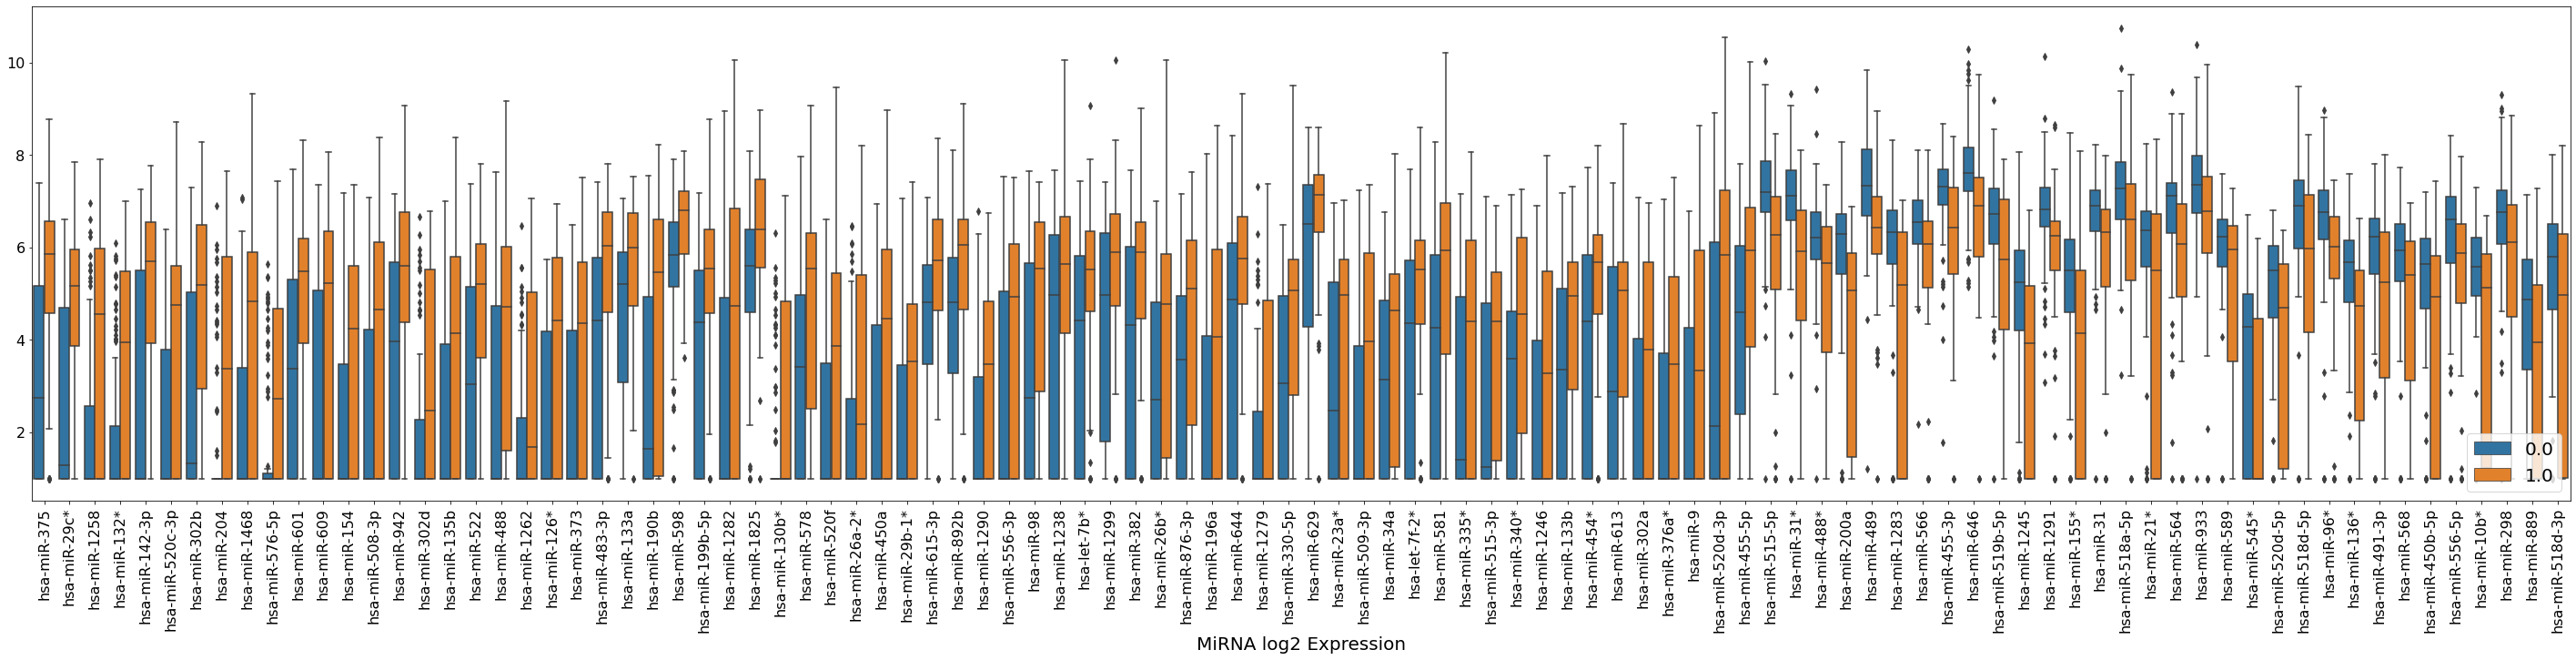

In [63]:
plt.figure(figsize=(50,10))
sns.boxplot(x="variable", y="value", hue='SD', data=df_melt);
plt.ylabel('', fontsize = 20)
plt.xlabel('MiRNA log2 Expression', fontsize = 20)
plt.legend(loc='lower right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expression.pdf', bbox_inches='tight')

In [4]:
X=df.drop('SD', axis=1)
y=df['SD']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

upsampling?

# RF

In [5]:
RF=RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [82]:
print('Model score on train set:')
print(RF.score(X_train, y_train))
print('Model score on train set:')
print(RF.score(X_val, y_val))

Model score on train set:
1.0
Model score on train set:
0.7333333333333333


In [127]:
imp=RF.feature_importances_
RF.feature_names_in_[imp.argsort()[-4:][::-1]]

array(['hsa-miR-483-3p', 'hsa-miR-373', 'hsa-miR-1291', 'hsa-miR-455-3p'],
      dtype=object)

## Grid Search

### All together

In [23]:
param_grid = {
    'n_estimators' : [50, 100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 6, 9, 15],
    'max_features' : [2, 3, 4, 5, 6]
}
base_estimator = RandomForestClassifier(random_state=1, n_jobs=-1)

grid_search=GridSearchCV(base_estimator, param_grid=param_grid,
                         cv=10, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 15],
                         'max_features': [2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 200, 300]})

In [25]:
print('Model score on train set:')
print(grid_search.score(X_train, y_train))
print('Model score on train set:')
print(grid_search.score(X_val, y_val))

Model score on train set:
1.0
Model score on train set:
0.7333333333333333


In [26]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 6,
 'n_estimators': 200}

In [28]:
RF_GS_all=grid_search.best_estimator_.fit(X_train, y_train)

In [29]:
imp=RF_GS_all.feature_importances_
RF_GS_all.feature_names_in_[imp.argsort()[-4:][::-1]]

array(['hsa-miR-31*', 'hsa-miR-1291', 'hsa-miR-483-3p', 'hsa-miR-96*'],
      dtype=object)

### Every time, I have ran the search for one parameter and add the best value for that parameter to the model




In [14]:
param_grid = {
    #'n_estimators' : [50, 100, 200, 300],
    #'criterion' : ['gini', 'entropy']
    #'max_depth' : [3, 6, 9, 15]
    'max_features' : [2, 3, 4, 5, 6]
}
base_estimator = RandomForestClassifier(random_state=1, n_jobs=-1)

grid_search=GridSearchCV(base_estimator, param_grid=param_grid,
                         cv=10, n_jobs=-1)

In [15]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1, param_grid={'max_features': [2, 3, 4, 5, 6]})

In [16]:
print('Model score on train set:')
print(grid_search.score(X_train, y_train))
print('Model score on train set:')
print(grid_search.score(X_val, y_val))

Model score on train set:
1.0
Model score on train set:
0.7333333333333333


In [17]:
grid_search.best_params_

{'max_features': 6}

In [32]:
RF_GS_1by1=RandomForestClassifier(n_estimators=200, max_depth=6, 
                                        max_features=6, criterion='entropy', 
                                        random_state=1, n_jobs=-1)
RF_GS_1by1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=6,
                       n_estimators=200, n_jobs=-1, random_state=1)

In [33]:
print('Model score on train set:')
print(RF_GS_1by1.score(X_train, y_train))
print('Model score on train set:')
print(RF_GS_1by1.score(X_val, y_val))

Model score on train set:
1.0
Model score on train set:
0.7333333333333333


In [34]:
imp=RF_GS_1by1.feature_importances_
RF_GS_1by1.feature_names_in_[imp.argsort()[-4:][::-1]]

array(['hsa-miR-31*', 'hsa-miR-1291', 'hsa-miR-483-3p', 'hsa-miR-96*'],
      dtype=object)

## The best 3 miRs

In [47]:
X_temp=df[['hsa-miR-31*', 'hsa-miR-1291', 'hsa-miR-483-3p']]
y_temp=df['SD']
X_train_val, X_test, y_train_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

In [48]:
RF2=RandomForestClassifier(random_state=1)
RF2.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [49]:
print('Model score on train set:')
print(RF2.score(X_train, y_train))
print('Model score on train set:')

print(RF2.score(X_val, y_val))

Model score on train set:
1.0
Model score on train set:
0.7333333333333333


# XGB